In [14]:
from ml_toolkit import df_to_X_y
from ml_toolkit import plot_predictions

import os
import sys
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'DejaVu Serif'

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam


| Date                | Point_1_N_mean | PT100_Temperature_mean | Average_Global_Radiation_(1h) | Day sin          | Day cos          | Year sin       | Year cos       |
|---------------------|----------------|------------------------|-------------------------------|------------------|------------------|----------------|----------------|
| 2020-09-02 12:00:00 | 18.324186      | 16.261441              | 954.0                         | 7.392965e-12     | -1.000000e+00    | -0.961130      | -0.276097      |
| 2020-09-03 12:00:00 | 24.667922      | 16.858222              | 966.0                         | 3.094426e-12     | -1.000000e+00    | -0.965740      | -0.259512      |
| 2020-09-04 10:00:00 | -15.535099     | 14.256647              | 131.6                         | 5.000000e-01     | -8.660254e-01    | -0.969715      | -0.244241      |
| 2020-09-04 14:00:00 | -10.819921     | 14.687477              | 314.0                         | -5.000000e-01    | -8.660254e-01    | -0.970411      | -0.241458      |
| 2020-09-04 18:00:00 | -15.399971     | 13.874647              | 236.0                         | -1.000000e+00    | -1.359232e-12    | -0.971100      | -0.238673      |


# Loading data

In [15]:
git_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML'))
asset_folder = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'HeroysundBridge-ML-Assets'))

print("Path to git folder:", git_folder)
print("Path to asset folder:", asset_folder)

Path to git folder: c:\Users\erlih\repos\HeroysundBridge-ML
Path to asset folder: c:\Users\erlih\repos\HeroysundBridge-ML-Assets


**Opening file: \silver\combined with relevant columns**

In [16]:
df = pd.read_parquet(os.path.join(asset_folder, 'silver','combined_data_v01.parquet'))
df.index = pd.to_datetime(df['Date'], format='%Y%m%d%H')
df.to_csv(os.path.join(asset_folder, 'silver','inspection.csv'))

**Adding relevant time/dates columns**

,Point_1_N_mean,PT100_Temperature_mean,Average_Global_Radiation_(1h),Relative_Humidity(1h),Precipitation_(1h),Average_of_Mean_Wind_(1h),Day sin,Day cos,Year sin,Year cos,days_since_start
Date,,,,,,,,,,,
2020-10-01 00:00:00,-72.143402,12.476844,0.0,71.0,0.0,1.1,-8.575893e-12,1.000000e+00,-0.977848,0.209315,0
2020-10-01 01:00:00,-74.569743,12.202079,0.0,75.0,0.0,1.5,2.588190e-01,9.659258e-01,-0.977698,0.210016,0
2020-10-01 02:00:00,-76.690182,11.993529,0.0,72.0,0.0,1.8,5.000000e-01,8.660254e-01,-0.977547,0.210717,0
2020-10-01 03:00:00,-78.859715,11.865803,0.0,77.0,0.0,1.8,7.071068e-01,7.071068e-01,-0.977396,0.211418,0
2020-10-01 04:00:00,-80.511559,11.889412,0.0,76.0,0.0,1.8,8.660254e-01,5.000000e-01,-0.977244,0.212119,0
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 18:00:00,-20.227229,-4.738139,-3.0,60.0,0.0,1.1,-1.000000e+00,-1.136945e-11,0.217723,0.976011,1186
2023-12-31 19:00:00,-19.488729,-4.625233,-3.0,59.0,0.0,1.3,-9.659258e-01,2.588190e-01,0.218423,0.975854,1186
2023-12-31 20:00:00,-21.503484,-4.645648,-2.9,57.0,0.0,1.3,-8.660254e-01,5.000000e-01,0.219123,0.975697,1186


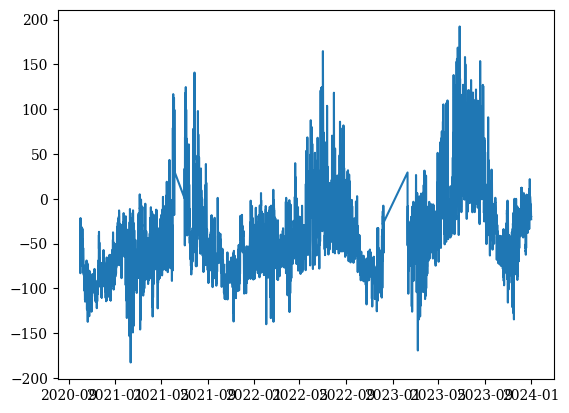

In [17]:
model_dataset = df[['Point_1_N_mean', 'PT100_Temperature_mean', 'Average_Global_Radiation_(1h)', 'Relative_Humidity(1h)', 'Precipitation_(1h)', 'Average_of_Mean_Wind_(1h)']]['2020-10-01 00:00:00':]#
model_dataset['seconds'] = model_dataset.index.map(pd.Timestamp.timestamp)
model_dataset['Day sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Day cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 86400))
model_dataset['Year sin'] = np.sin(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['Year cos'] = np.cos(model_dataset['seconds'] * (2 * np.pi / 31536000))
model_dataset['days_since_start'] = (model_dataset.index - model_dataset.index[0]).days
model_dataset.drop(columns=['seconds'], inplace=True)
display(model_dataset)
plt.plot(model_dataset.index, model_dataset['Point_1_N_mean'])

# Train-, val- and testing split +++ Scaling

In [18]:
dataset_size = len(model_dataset)
training_split = int(0.72 * dataset_size)
validation_split = int(0.18 * dataset_size)
test_split = dataset_size - training_split - validation_split
print(f"Training split: {training_split}, Validation split: {validation_split}, Test split: {test_split}")
assert training_split + validation_split + test_split == dataset_size, "Invalid split sizes"

Training split: 19000, Validation split: 4750, Test split: 2640


In [19]:
print(model_dataset[:training_split])
print("-------------------")
print(model_dataset[training_split:-test_split])
print("-------------------")
print(model_dataset[-test_split:])

                     Point_1_N_mean  PT100_Temperature_mean  \
Date                                                          
2020-10-01 00:00:00      -72.143402               12.476844   
2020-10-01 01:00:00      -74.569743               12.202079   
2020-10-01 02:00:00      -76.690182               11.993529   
2020-10-01 03:00:00      -78.859715               11.865803   
2020-10-01 04:00:00      -80.511559               11.889412   
...                             ...                     ...   
2023-02-27 01:00:00      -66.058142                4.486058   
2023-02-27 02:00:00      -66.031556                4.555233   
2023-02-27 03:00:00      -65.171898                4.561771   
2023-02-27 04:00:00      -65.656438                4.451549   
2023-02-27 05:00:00      -66.396812                4.327346   

                     Average_Global_Radiation_(1h)  Relative_Humidity(1h)  \
Date                                                                        
2020-10-01 00:00:00       

**Assigning labels and targets - x- and y- train,-val and -test**

In [20]:
window_size = 24*30

X, y = df_to_X_y(model_dataset, window_size)
print(X.shape, y.shape)

# Splitting the data into training, validation and test sets
X_train, y_train = X[:training_split], y[:training_split]
X_valid, y_valid = X[training_split:(training_split + validation_split)], y[training_split:(training_split + validation_split)]
X_test, y_test = X[-test_split:], y[-test_split:]
print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape)

(25670, 720, 10) (25670,)
(19000, 720, 10) (19000,) (4750, 720, 10) (4750,) (2640, 720, 10) (2640,)


**Normlaization**

In [21]:
# Reshape to 2D (Normalisation requires 2D input)
X_train_2D = np.reshape(X_train, (X_train.shape[0] * X_train.shape[1], X_train.shape[2]))
X_valid_2D = np.reshape(X_valid, (X_valid.shape[0] * X_valid.shape[1], X_valid.shape[2]))
X_test_2D = np.reshape(X_test, (X_test.shape[0] * X_test.shape[1], X_test.shape[2]))

# Apply scaling
scaler_x = StandardScaler()
X_train_scaled_2D = scaler_x.fit_transform(X_train_2D)
X_valid_scaled_2D = scaler_x.transform(X_valid_2D)
X_test_scaled_2D = scaler_x.transform(X_test_2D)

# Reshape back to 3D
X_train_scaled = np.reshape(X_train_scaled_2D, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_valid_scaled = np.reshape(X_valid_scaled_2D, (X_valid.shape[0], X_valid.shape[1], X_valid.shape[2]))
X_test_scaled = np.reshape(X_test_scaled_2D, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

# LSTM Model 2

In [22]:
model_name = 'conv_model_point_1_N_001'
batch_size = 128
epochs = 200
learning_rate = 0.001
patience = 12
verbose = 1
saving_frequency = 8

In [23]:
model = Sequential()
model.add(InputLayer((window_size, (len(model_dataset.columns)-1))))

model.add(Conv1D(64, kernel_size=2, activation='relu'))
model.add(Flatten())

model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 719, 64)           1344      
                                                                 
 flatten_1 (Flatten)         (None, 46016)             0         
                                                                 
 dense_2 (Dense)             (None, 8)                 368136    
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 369489 (1.41 MB)
Trainable params: 369489 (1.41 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
cp = ModelCheckpoint(os.path.join(asset_folder, 'gold', str(model_name)), save_best_only=True, mode='auto', verbose=verbose)
es = EarlyStopping(monitor='val_loss', patience=patience, mode='auto', verbose=verbose)
model.compile(optimizer=Adam(learning_rate), loss='mse', metrics=['mae'])
history = model.fit(X_train_scaled, y_train_scaled, validation_data=(X_valid_scaled, y_valid_scaled), epochs=epochs, batch_size=batch_size, callbacks=[es,cp], verbose=verbose) 

Epoch 1/200
148/149 [============================>.] - ETA: 0s - loss: 0.4600 - mae: 0.4913
Epoch 1: val_loss improved from inf to 0.76575, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001\assets


149/149 [==============================] - 3s 19ms/step - loss: 0.4594 - mae: 0.4910 - val_loss: 0.7657 - val_mae: 0.7005
Epoch 2/200
149/149 [==============================] - ETA: 0s - loss: 0.2131 - mae: 0.3361
Epoch 2: val_loss improved from 0.76575 to 0.58978, saving model to c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001
INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001\assets


INFO:tensorflow:Assets written to: c:\Users\erlih\repos\HeroysundBridge-ML-Assets\gold\conv_model_point_1_N_001\assets


149/149 [==============================] - 3s 18ms/step - loss: 0.2131 - mae: 0.3361 - val_loss: 0.5898 - val_mae: 0.6186
Epoch 3/200
148/149 [============================>.] - ETA: 0s - loss: 0.1969 - mae: 0.3129
Epoch 3: val_loss did not improve from 0.58978
149/149 [==============================] - 2s 16ms/step - loss: 0.1969 - mae: 0.3130 - val_loss: 0.7805 - val_mae: 0.7365
Epoch 4/200
147/149 [============================>.] - ETA: 0s - loss: 0.1874 - mae: 0.2950
Epoch 4: val_loss did not improve from 0.58978
149/149 [==============================] - 2s 15ms/step - loss: 0.1877 - mae: 0.2951 - val_loss: 0.6542 - val_mae: 0.6600
Epoch 5/200
148/149 [============================>.] - ETA: 0s - loss: 0.1819 - mae: 0.2829
Epoch 5: val_loss did not improve from 0.58978
149/149 [==============================] - 2s 13ms/step - loss: 0.1818 - mae: 0.2828 - val_loss: 0.7989 - val_mae: 0.7425
Epoch 6/200
149/149 [==============================] - ETA: 0s - loss: 0.1785 - mae: 0.2742
Epo

**Visualization of ML-metrics**

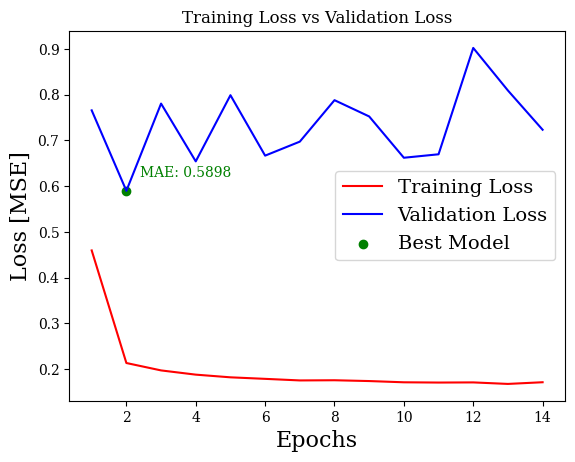

In [25]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(train_loss) + 1)

# Get the index of the best model
best_model_index = np.argmin(val_loss)

# Plot the training loss vs validation loss
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.scatter(best_model_index + 1, val_loss[best_model_index], color='g', label='Best Model')
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss [MSE]',fontsize=16)
plt.legend(fontsize=14)

# Display the MAE value of the best model
best_model_mae = val_loss[best_model_index]
plt.annotate(f'MAE: {best_model_mae:.4f}', (best_model_index + 1, best_model_mae), xytext=(10, 10),
             textcoords='offset points', color='g')

plt.show()

### Predictions

83/83 [==============================] - 0s 1ms/step


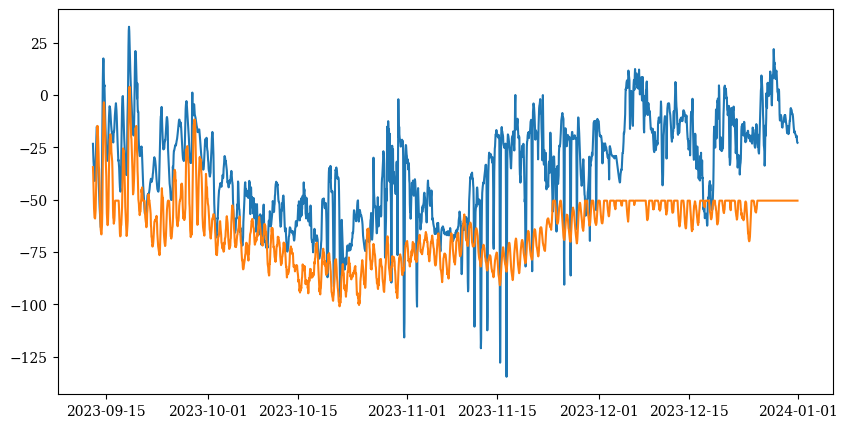

MSE: 1131.1998291015625
MAE: 29.259191513061523
R^2 Score: -0.9973209608011906


,Predictions,Actuals
0,-34.412773,-23.290602
1,-37.923794,-27.657445
2,-43.883667,-31.505560
3,-48.474220,-33.448184
4,-53.869762,-35.554206
...,...,...
2635,-50.431885,-20.227229
2636,-50.431885,-19.488729
2637,-50.431885,-21.503484
2638,-50.431885,-22.667015


In [26]:
from sklearn.metrics import r2_score as score

model_file_path = os.path.join(asset_folder, 'gold', model_name)
model = load_model(model_file_path)
plot_predictions(model_dataset, test_split, model, X_test_scaled, y_test, start=0, end=test_split, scaler=scaler_y)
#print(f"R^2 Score: {score(X_test_scaled, y_test)}")